In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import string
import re

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Classifying Jobs as Data Science or Non-Data Science

In [2]:
df = pd.read_csv('second_scrape_w_text.csv', index_col=0)
# 1 indicates data science, 0 indicates non data science
df['target'] = df['file'].apply(lambda x: 0 if x == 'business-analyst' else 1)

In [3]:
df = df[['job_title', 'job_company', 'target', 'job_description', 'job_text', 'job_employment_type', 'job_ids', 'job_industry', 
         'job_sub_industry', 'job_location', 'job_sub_location', 'description_len', 'job_urls']]

In [4]:
df.head()

,job_title,job_company,target,job_description,job_text,job_employment_type,job_ids,job_industry,job_sub_industry,job_location,job_sub_location,description_len,job_urls
0,Big Data Engineer - (Scala or Java or Python),Big Wednesday,1,Big Data Engineer - US Dot-com Company,Big Data Engineer - US Dot-com Company Require...,Full Time,34455993,Information & Communication Technology,Engineering - Software,Melbourne,Unknown,7.0,https://www.seek.com.au/job/34455993
1,"Head of Big Data - Relocate to Bangkok, Thailand",Big Wednesday,1,Our client a leading IT company in Asia is cur...,Our client a leading IT company in Asia is cur...,Full Time,34445914,Information & Communication Technology,Management,Melbourne,Unknown,26.0,https://www.seek.com.au/job/34445914
2,"Senior DevOps Engineer, with appreciation of B...",Just Digital People,1,Senior Devops Engineer with an appreciation Bi...,DevOps / Site Reliability Engineer (AWS) New p...,Full Time,34433930,Information & Communication Technology,Engineering - Software,Sydney,"CBD, Inner West & Eastern Suburbs",12.0,https://www.seek.com.au/job/34433930
3,Head of Big Data Engineering - CBD-based,FourQuarters Recruitment,1,Head of Big Data required to build and manage ...,Head of Big Data required to build and manage ...,Full Time,34413441,Information & Communication Technology,Other,Melbourne,Unknown,18.0,https://www.seek.com.au/job/34413441
4,"Big Data Engineer - Hadoop, AWS",FourQuarters Recruitment,1,Big Data Engineer required to join a leading f...,Big Data Engineer required to join a leading f...,Full Time,34413442,Information & Communication Technology,Developers/Programmers,Melbourne,Unknown,11.0,https://www.seek.com.au/job/34413442


In [5]:
def convert_camelcase(name):
    '''Convert CamelCase to camel case'''
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1 \2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1 \2', s1).lower()

In [6]:
# going through and removing punctuation from text features
exclude = set(string.punctuation)

for col in ['job_title', 'job_description', 'job_text', 'job_industry', 'job_sub_industry']:
    for idx, row in df.iterrows():
        s = row[col]
        s = ''.join(ch for ch in s if ch not in exclude)
        # removing punctuation caused words to be glued together, this function was used to insert a whitespace
        s = convert_camelcase(s)
        df.loc[idx, col] = s.replace('  ',' ')
    
    # attempt at removing numerics from the text features
    for num in range(9):
        df[col] = df[col].str.replace(str(num),'')
        
    df[col] = df[col].str.replace('  ', ' ')

In [7]:
# iterating through rows that seem to be dev jobs
developer_indices = []
for i, job in enumerate(df['job_title']):
    for title in ['developer', 'stack']:
        if title in job:
            developer_indices.append(i)

In [8]:
pd.Series(developer_indices).nunique()

93

In [9]:
# mapping the dev jobs to be non-data science jobs
df.loc[pd.Series(developer_indices).unique(), 'target'] = 0

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
# 'mnb':MultinomialNB(), 
# 'mnb_bag':BaggingClassifier(MultinomialNB(), random_state=42), 
# 'bnb':BernoulliNB(),
# 'bnb_bag':BaggingClassifier(BernoulliNB(), random_state=42),

classifiers = {'lgr':LogisticRegression(random_state=42), 
               'lgr_bag':BaggingClassifier(LogisticRegression(random_state=42), random_state=42), 
               'gbc':GradientBoostingClassifier(), 
               'gbc_bag':BaggingClassifier(GradientBoostingClassifier(), random_state=42), 
               'abc':AdaBoostClassifier(random_state=42),
               'abc_bag':BaggingClassifier(AdaBoostClassifier(random_state=42), random_state=42),
               'rfc':RandomForestClassifier(n_estimators=200, random_state=42)}

In [13]:
results = {}
for i in range(100, 500, 25):
    temp_results = []
    X_train, X_test, y_train, y_test = train_test_split(df['job_text'], df['target'].values, test_size=0.33, random_state=42)
    
    tf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=i)
    
    X_train = tf.fit_transform(X_train).todense()
    X_test = tf.transform(X_test).todense()
    
    for clf in classifiers.items():
        clf[1].fit(X_train, y_train)
        temp_results.append([clf[0], clf[1].score(X_test, y_test)])
    results.update({i: temp_results})

In [14]:
best_score = ['clf', 'max_features', 0]
for i, clf in enumerate(classifiers):
    for k in results.keys():
        if results[k][i][1] > best_score[2]:
            best_score = [results[k][i][0], k, results[k][i][1]]

In [15]:
best_score

['lgr', 425, 0.88852459016393448]

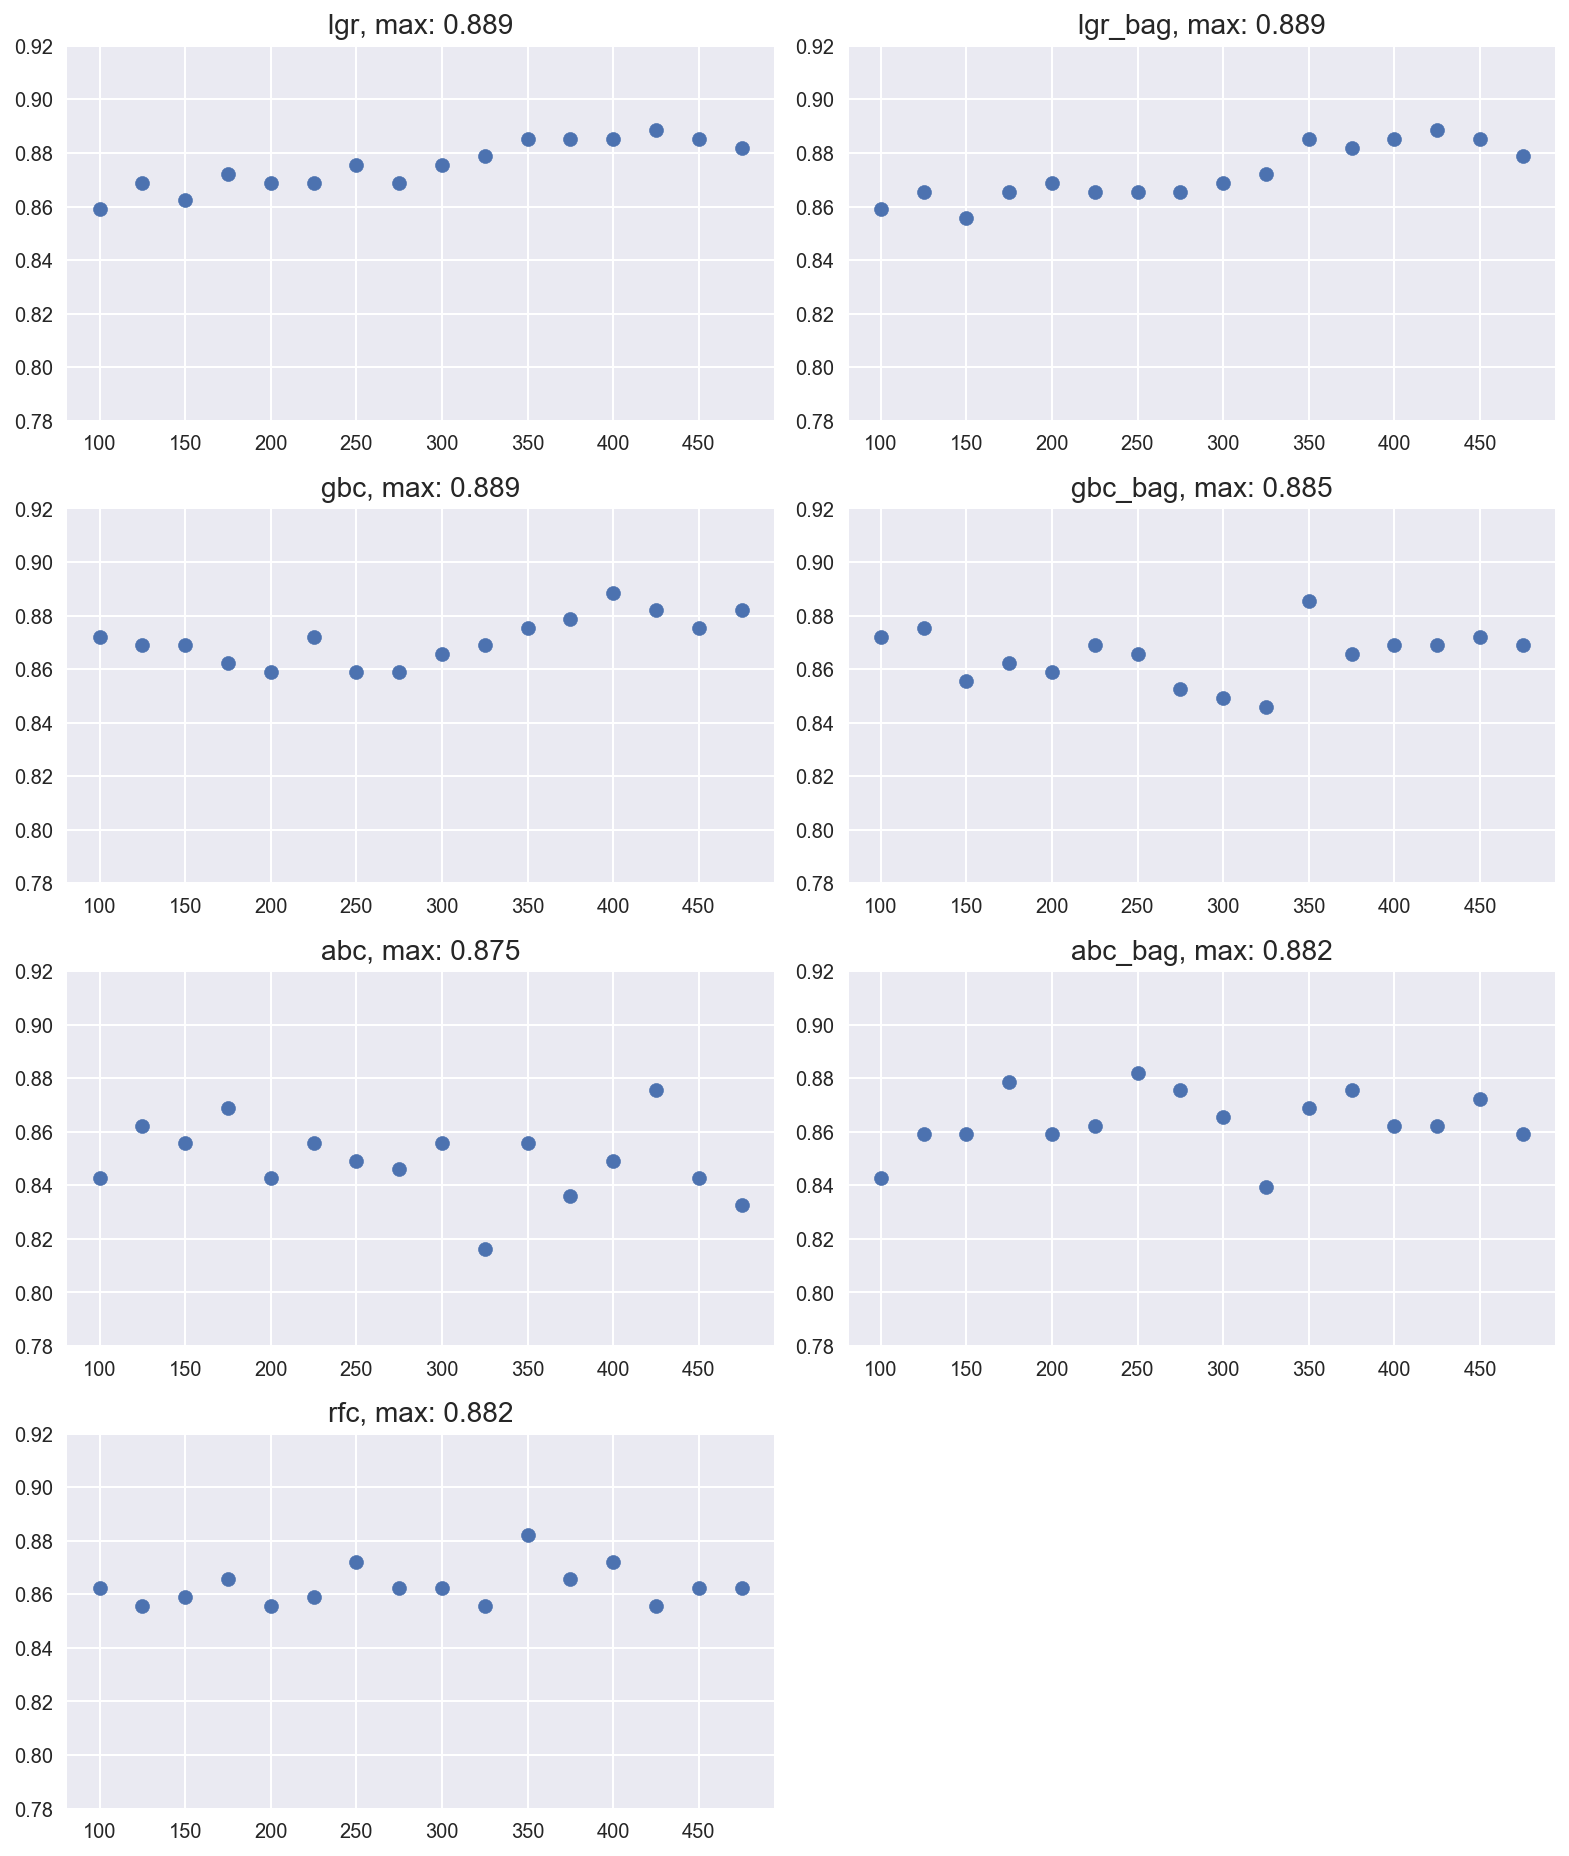

In [16]:
plt.figure(figsize = (11,13))
for i, clf in enumerate(classifiers):
    y_coords = []
    for k in results.keys():
        y_coords.append(results[k][i][1])
    plt.subplot(4,2,i+1), plt.scatter(x = list(range(100, 500, 25)), y = y_coords)
    plt.title(str(clf) + ', max: {}'.format(round(max(y_coords),3)), fontsize = 14)
    plt.yticks(np.arange(0.78, 0.94, 0.02))
plt.tight_layout()

In [17]:
baseline = df['target'].mean()
baseline

0.5553145336225597

In [18]:
# splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(df['job_text'], df['target'].values, test_size=0.33, random_state=42)

# creating a sparse matrix of the job text
tf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=100)
X_train = tf.fit_transform(X_train).todense()
X_test = tf.transform(X_test).todense()

In [19]:
gbc = BaggingClassifier(GradientBoostingClassifier(random_state=42), random_state=42)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

0.87213114754098364

In [20]:
gbc_preds = gbc.predict(X_test)
gbc_preds_prob = gbc.predict_proba(X_test)

pd.crosstab(y_test, gbc_preds, rownames = ['actual'], 
            colnames = ['predictions'], margins = True)

predictions,0,1,All
actual,,,
0,118,23,141
1,16,148,164
All,134,171,305


**35 misclassifications or 305 data points, model is 88 percent accurate**

Checking Feature Importances with Random Forest

In [21]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

results = pd.DataFrame()
results['word'] = tf.get_feature_names()
results['coef'] = rfc.feature_importances_

In [22]:
results.sort_values(by = 'coef', ascending = False, inplace = True)
best = results['word'].head(10).reset_index(drop = True)
worst = results['word'].tail(10).reset_index(drop = True)

In [23]:
best_worst = pd.DataFrame({'best': best, 'worst': worst})
best_worst

,best,worst
0,business analyst,opportunities
1,data,high
2,business,required
3,research,services
4,machine learning,use
5,requirements,industry
6,development,candidate
7,analyst,models
8,analytics,learning
9,statistical,ability


In [24]:
from sklearn.metrics import classification_report

In [25]:
print(classification_report(y_test, gbc_preds, target_names = ['non data-science', 'data-science']))

                  precision    recall  f1-score   support

non data-science       0.88      0.84      0.86       141
    data-science       0.87      0.90      0.88       164

     avg / total       0.87      0.87      0.87       305



In [26]:
tp = np.sum((y_test == 1) & (gbc_preds == 1))
fp = np.sum((y_test == 0) & (gbc_preds == 1))
tn = np.sum((y_test == 0) & (gbc_preds == 0))
fn = np.sum((y_test == 1) & (gbc_preds == 0))
tp, fp, tn, fn

(148, 23, 118, 16)

In [27]:
df_prob_gbc = pd.DataFrame(data = gbc_preds_prob, columns = ['false', 'true'])

In [28]:
df_prob_gbc.head()

,false,true
0,0.982644,0.017356
1,0.950718,0.049282
2,0.249069,0.750931
3,0.854622,0.145378
4,0.529037,0.470963


In [29]:
from sklearn.metrics import roc_curve, auc

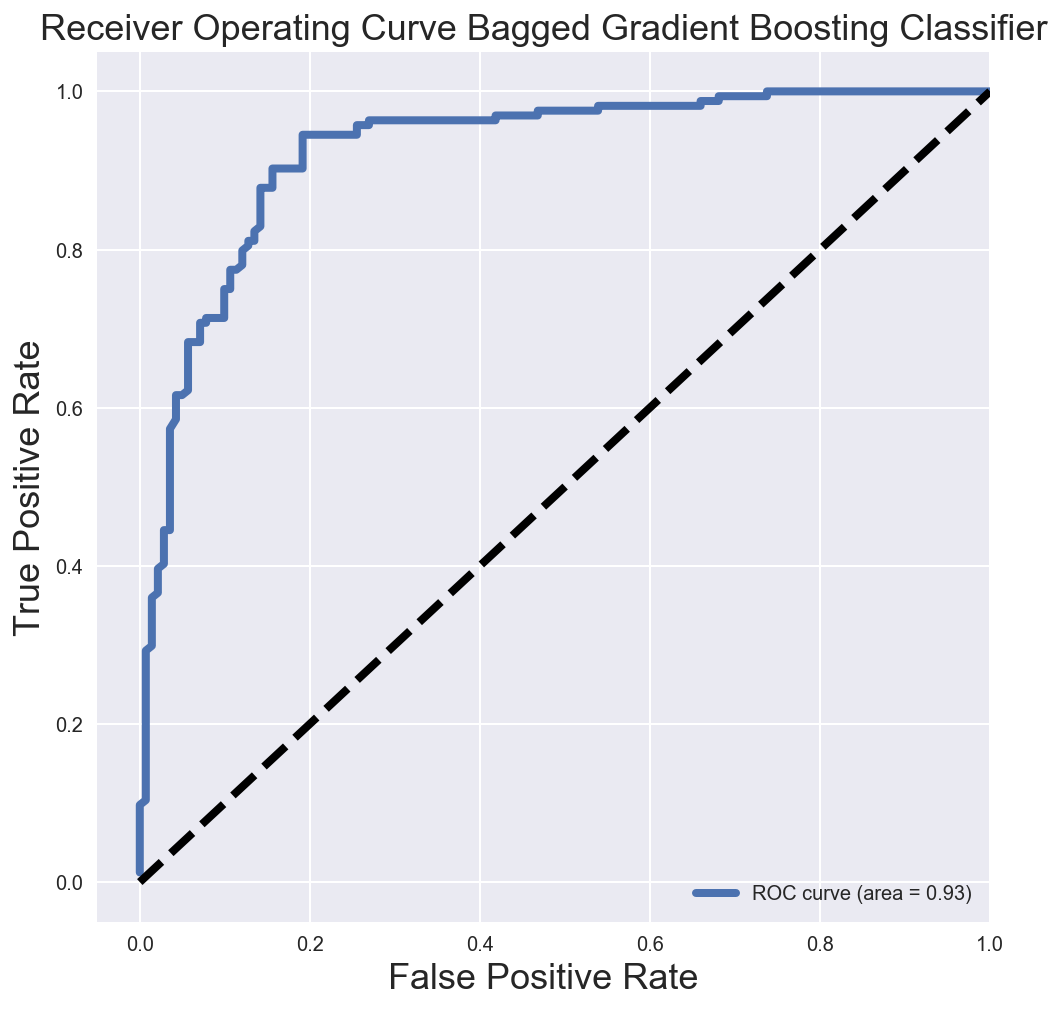

In [30]:
fpr, tpr, _ = roc_curve(y_test, df_prob_gbc['true'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)

plt.title('Receiver Operating Curve Bagged Gradient Boosting Classifier', fontsize=18)
plt.legend(loc="lower right");

### Classifying between Senior roles and Non-Senior

In [31]:
# grab indices relating to senior positions
senior_indices = []
for i, job in enumerate(df['job_title']):
    for title in ['senior', 'head', 'director', 'lead']:
        if title in job:
            senior_indices.append(i)

In [32]:
# unique() is used to remove duplication between jobs that have multiple 
# senior defining titles
pd.Series(senior_indices).values

array([  1,   2,   3,  15,  16,  17,  18,  21,  27,  36,  40,  41,  51,
        53,  54,  56,  57,  58,  59,  60,  67,  68,  69,  70,  76,  76,
        78,  79,  84,  94,  95,  97,  98, 101, 104, 105, 106, 112, 114,
       117, 122, 126, 127, 129, 131, 133, 137, 148, 149, 150, 151, 161,
       163, 165, 177, 182, 183, 185, 200, 201, 207, 208, 209, 213, 215,
       216, 218, 220, 227, 229, 230, 231, 232, 236, 240, 245, 256, 264,
       282, 284, 290, 293, 294, 308, 315, 317, 318, 318, 322, 323, 328,
       341, 343, 346, 347, 349, 365, 372, 373, 375, 380, 381, 387, 391,
       393, 407, 408, 419, 423, 428, 429, 460, 476, 477, 482, 483, 487,
       491, 495, 497, 502, 504, 509, 511, 513, 524, 528, 529, 538, 541,
       548, 549, 551, 552, 557, 558, 562, 568, 584, 585, 588, 591, 595,
       599, 600, 604, 607, 610, 613, 614, 617, 618, 619, 628, 631, 632,
       633, 635, 648, 659, 660, 669, 674, 675, 677, 678, 681, 694, 701,
       704, 706, 707, 708, 709, 710, 711, 712, 713, 717, 720, 72

In [33]:
# mapping senior jobs to target = 1
df['target'] = 1
df.loc[pd.Series(senior_indices).values, 'target'] = 0

In [34]:
results = {}
for i in range(100, 500, 25):
    temp_results = []
    X_train, X_test, y_train, y_test = train_test_split(df['job_text'], df['target'].values, test_size=0.33, random_state=42)
    
    tf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=i)
    
    X_train = tf.fit_transform(X_train).todense()
    X_test = tf.transform(X_test).todense()
    
    for clf in classifiers.items():
        clf[1].fit(X_train, y_train)
        temp_results.append([clf[0], clf[1].score(X_test, y_test)])
    results.update({i: temp_results})

In [35]:
best_score = ['clf', 'max_features', 0]
for i, clf in enumerate(classifiers):
    for k in results.keys():
        if results[k][i][1] > best_score[2]:
            best_score = [results[k][i][0], k, results[k][i][1]]

In [36]:
best_score

['gbc_bag', 350, 0.89836065573770496]

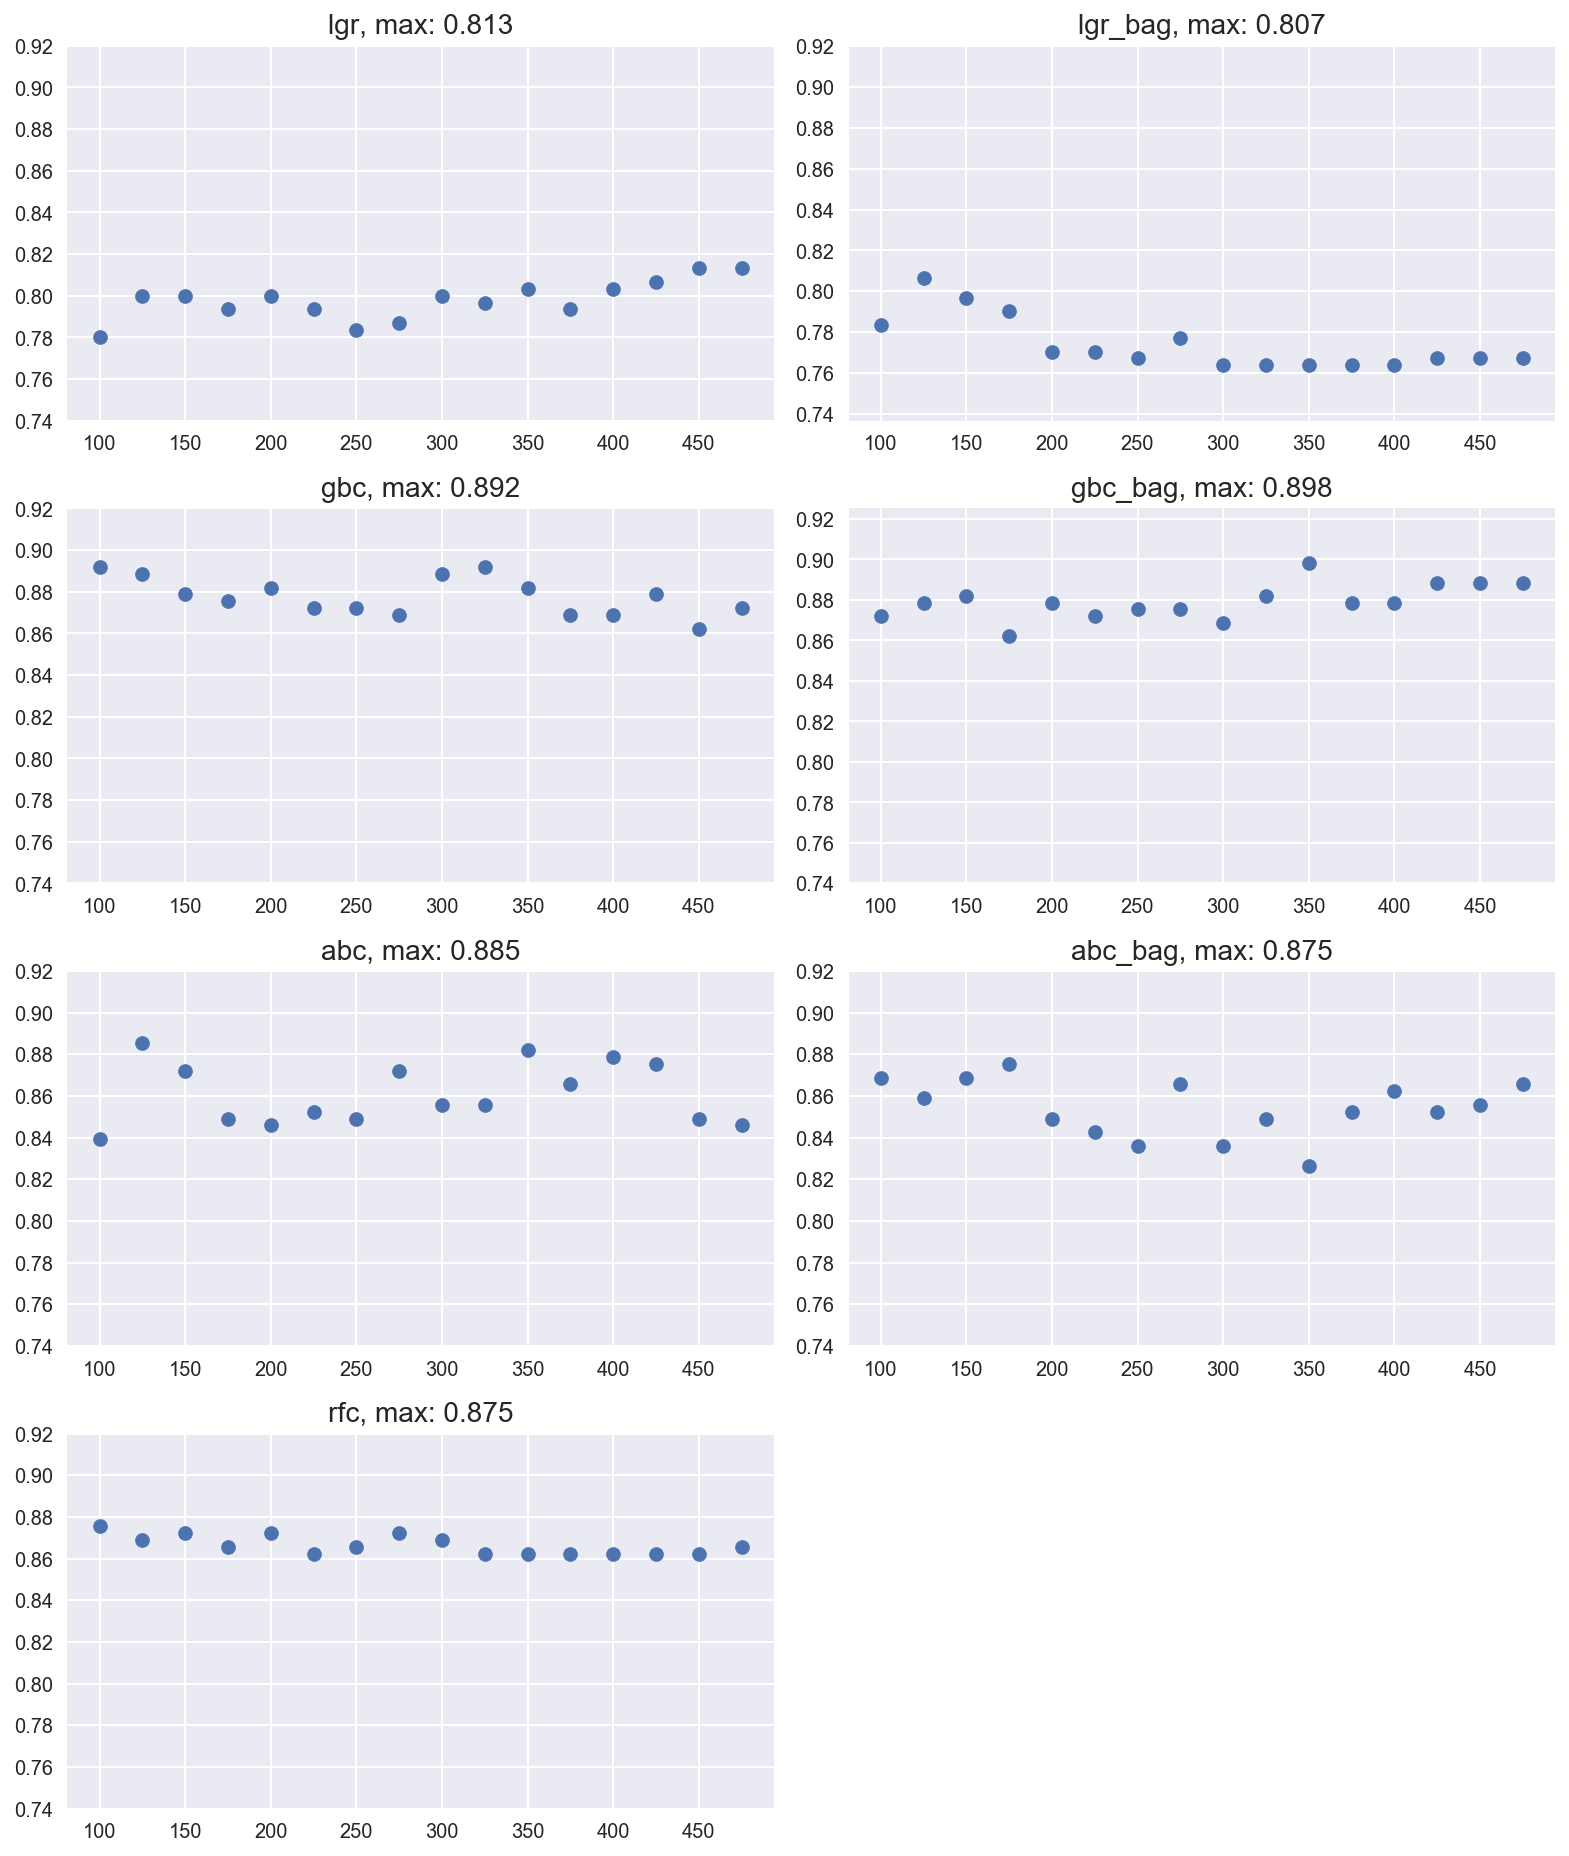

In [37]:
plt.figure(figsize = (11,13))
for i, clf in enumerate(classifiers):
    y_coords = []
    for k in results.keys():
        y_coords.append(results[k][i][1])
    plt.subplot(4,2,i+1), plt.scatter(x = list(range(100, 500, 25)), y = y_coords)
    plt.title(str(clf) + ', max: {}'.format(round(max(y_coords),3)), fontsize = 14)
    plt.yticks(np.arange(0.74, 0.92, 0.02))
plt.tight_layout()

In [38]:
baseline = df['target'].mean()
baseline

0.7321041214750542

In [39]:
# splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(df['job_text'], df['target'].values, test_size=0.33, random_state=42)

# creating a sparse matrix of the job text
tf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=350)
X_train = tf.fit_transform(X_train).todense()
X_test = tf.transform(X_test).todense()

In [40]:
gbc = BaggingClassifier(GradientBoostingClassifier(random_state=42), random_state=42)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

0.89836065573770496

In [41]:
gbc_preds = gbc.predict(X_test)
gbc_preds_prob = gbc.predict_proba(X_test)

pd.crosstab(y_test, gbc_preds, rownames = ['actual'], 
            colnames = ['predictions'], margins = True)

predictions,0,1,All
actual,,,
0,60,23,83
1,8,214,222
All,68,237,305


**31 misclassifications out of 305 data points, 89.83 percent accurate.**

In [42]:
tp = np.sum((y_test == 1) & (gbc_preds == 1))
fp = np.sum((y_test == 0) & (gbc_preds == 1))
tn = np.sum((y_test == 0) & (gbc_preds == 0))
fn = np.sum((y_test == 1) & (gbc_preds == 0))
tp, fp, tn, fn

(214, 23, 60, 8)

In [43]:
df_prob_gbc = pd.DataFrame(data = gbc_preds_prob, columns = ['false', 'true'])
df_prob_gbc.head()

,false,true
0,0.350558,0.649442
1,0.053892,0.946108
2,0.342622,0.657378
3,0.075160,0.924840
4,0.072991,0.927009


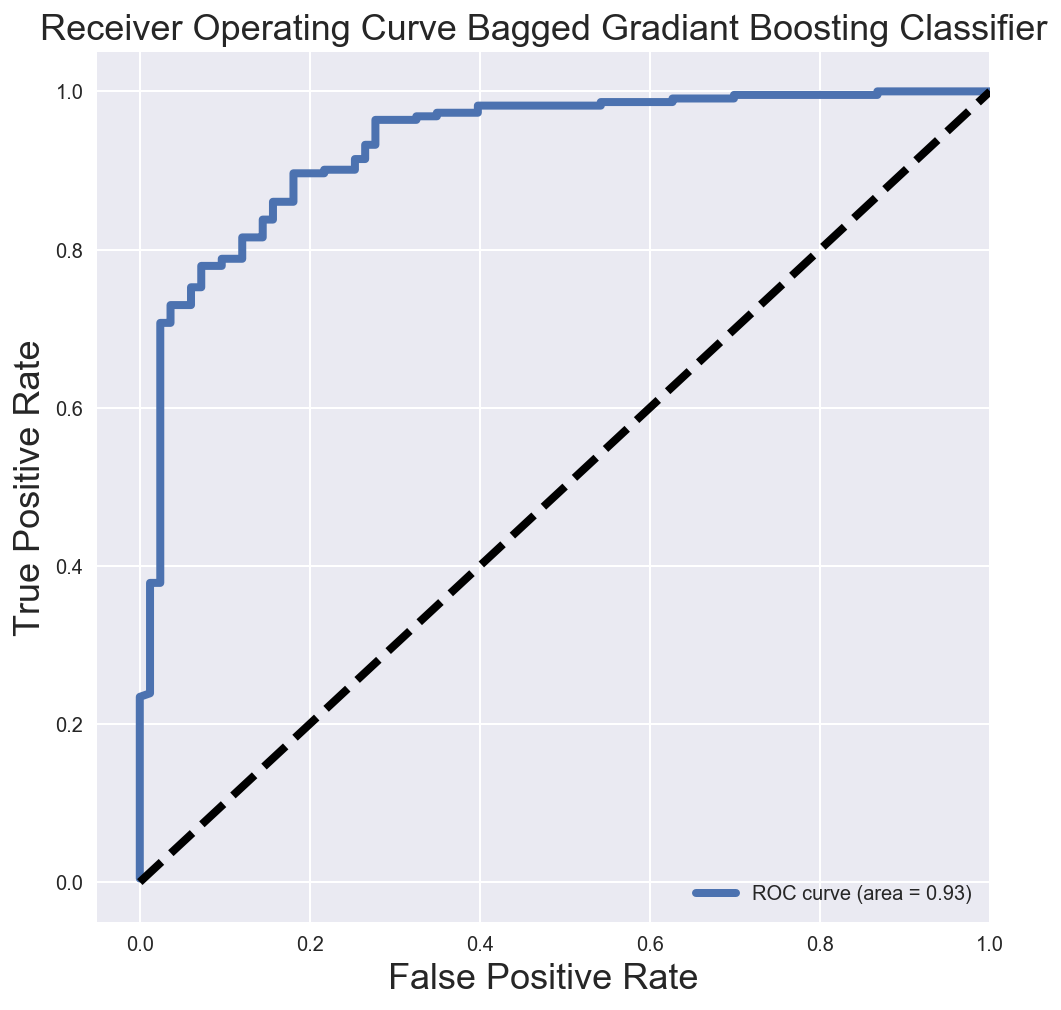

In [44]:
fpr, tpr, _ = roc_curve(y_test, df_prob_gbc['true'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)

plt.title('Receiver Operating Curve Bagged Gradiant Boosting Classifier', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Predicting Salary

In [45]:
df = pd.read_csv('second_scrape_w_text.csv', index_col=0)

# masking senior as a feature
df.loc[senior_indices, 'senior'] = 1
df.loc[df['senior'] != 1, 'senior'] = 0

# excluding Business Analyst lines
df = df[df['file'] != 'business-analyst'].copy()
df.reset_index(inplace = True, drop = True)

df.drop(['job_bullets', 'job_salary', 'salary_k', 'salary_comma', 'salary_lower', 'salary_upper', 'file'], axis = 1, inplace = True)

df = df[['job_title', 'job_company', 'salary', 'senior', 'job_description', 'job_text', 'job_employment_type', 'job_ids', 'job_industry', 
         'job_sub_industry', 'job_location', 'job_sub_location', 'description_len', 'job_urls']].copy()

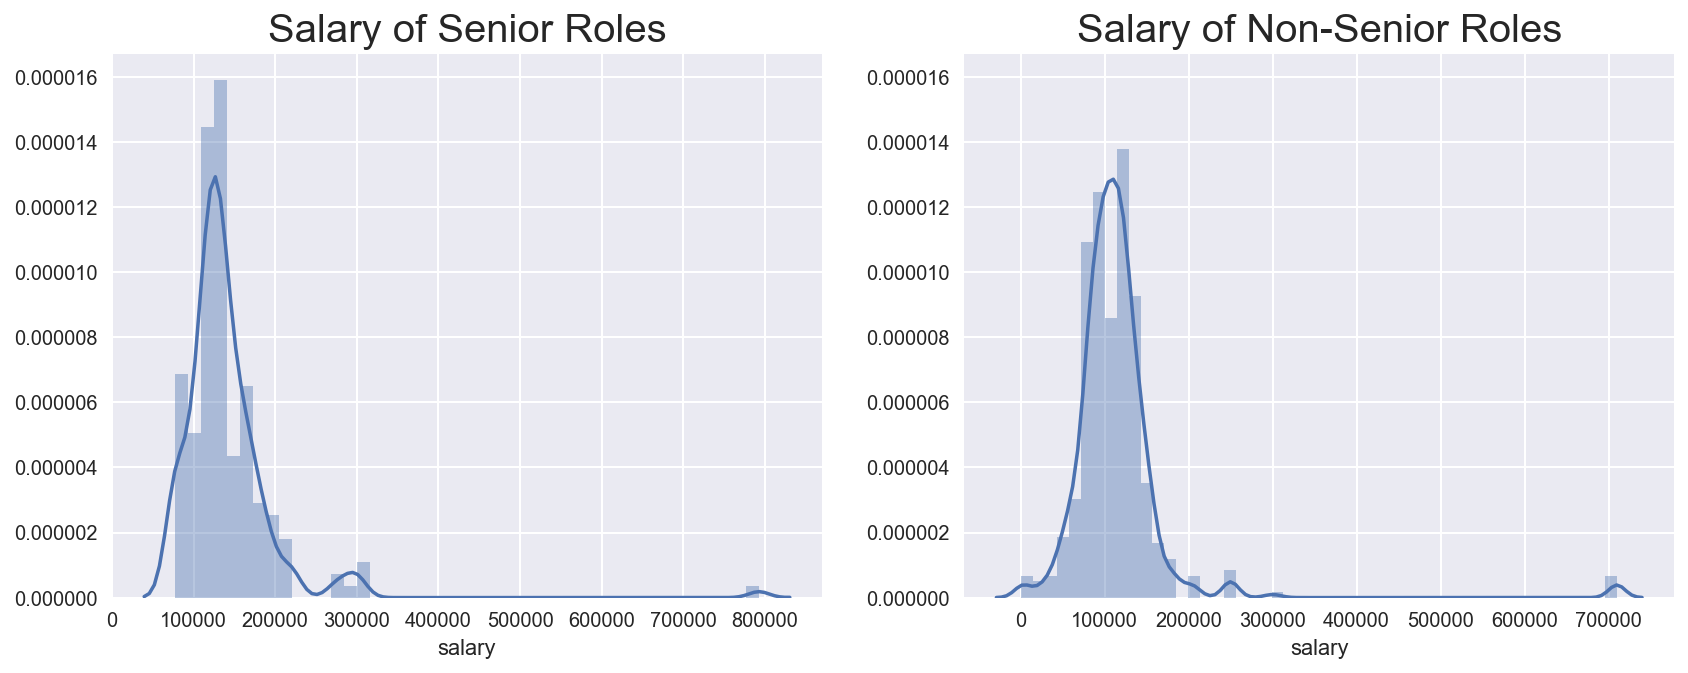

In [46]:
plt.figure(figsize = [14,5])
plt.subplot(1,2,1), sns.distplot(df[df['senior'] == 1]['salary'])
plt.title('Salary of Senior Roles', fontsize = 20);

# mimimum value of 1,000 should probably be 100,000
plt.subplot(1,2,2, sharey=plt.subplot(1,2,1)), sns.distplot(df[df['senior'] == 0]['salary'])
plt.title('Salary of Non-Senior Roles', fontsize = 20);

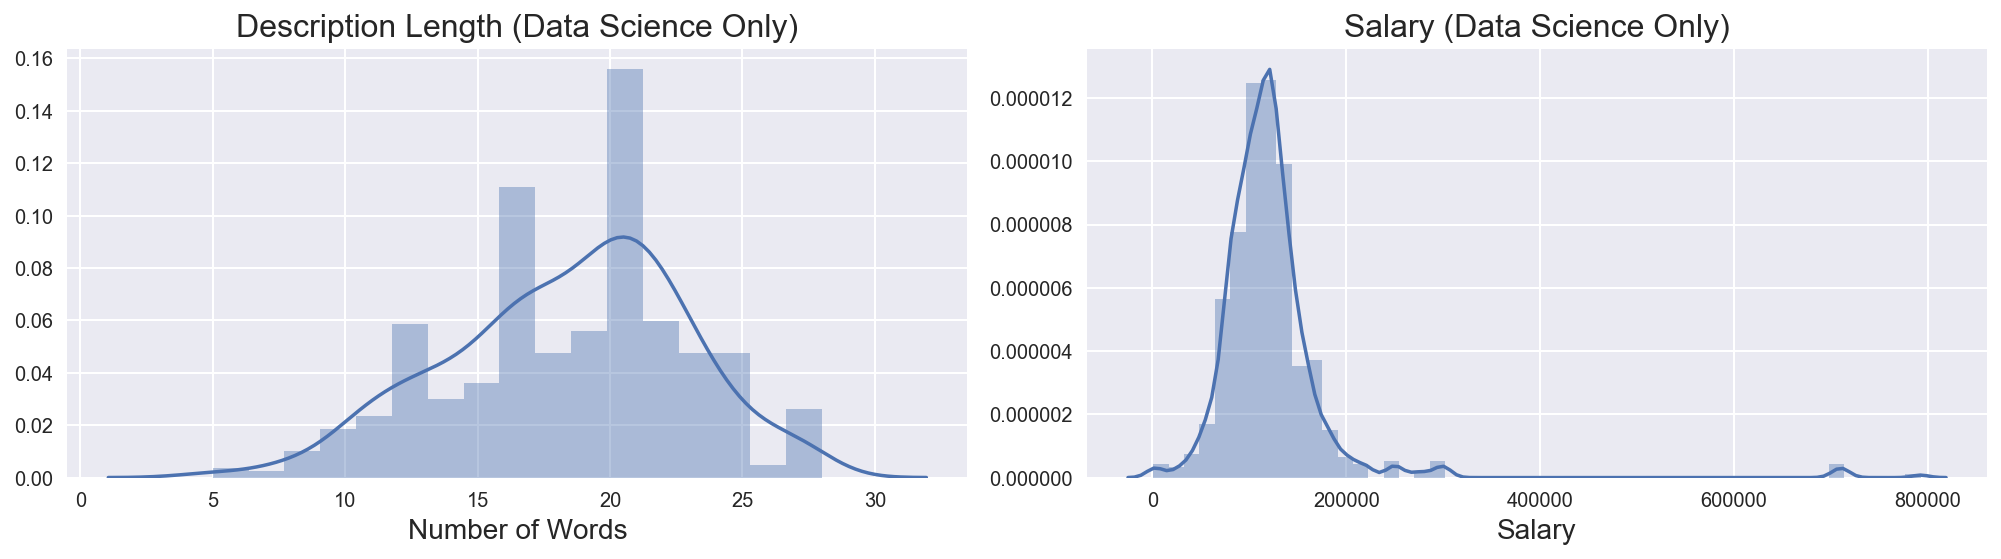

In [47]:
plt.figure(figsize = [14,4])
plt.subplot(1,2,1), sns.distplot(df['description_len'])
plt.title('Description Length (Data Science Only)', fontsize = 16)
plt.xlabel('Number of Words', fontsize = 14)

plt.subplot(1,2,2), sns.distplot(df['salary'])
plt.title('Salary (Data Science Only)', fontsize = 16)
plt.xlabel('Salary', fontsize = 14)
plt.tight_layout();

In [48]:
df.head(1)

,job_title,job_company,salary,senior,job_description,job_text,job_employment_type,job_ids,job_industry,job_sub_industry,job_location,job_sub_location,description_len,job_urls
0,Big Data Engineer - (Scala or Java or Python),Big Wednesday,85000.0,0.0,Big Data Engineer - US Dot-com Company,Big Data Engineer - US Dot-com Company Require...,Full Time,34455993,Information & Communication Technology,Engineering - Software,Melbourne,Unknown,7.0,https://www.seek.com.au/job/34455993


In [49]:
subset = df[df['job_location'].isin(['Sydney', 'Melbourne'])].copy()

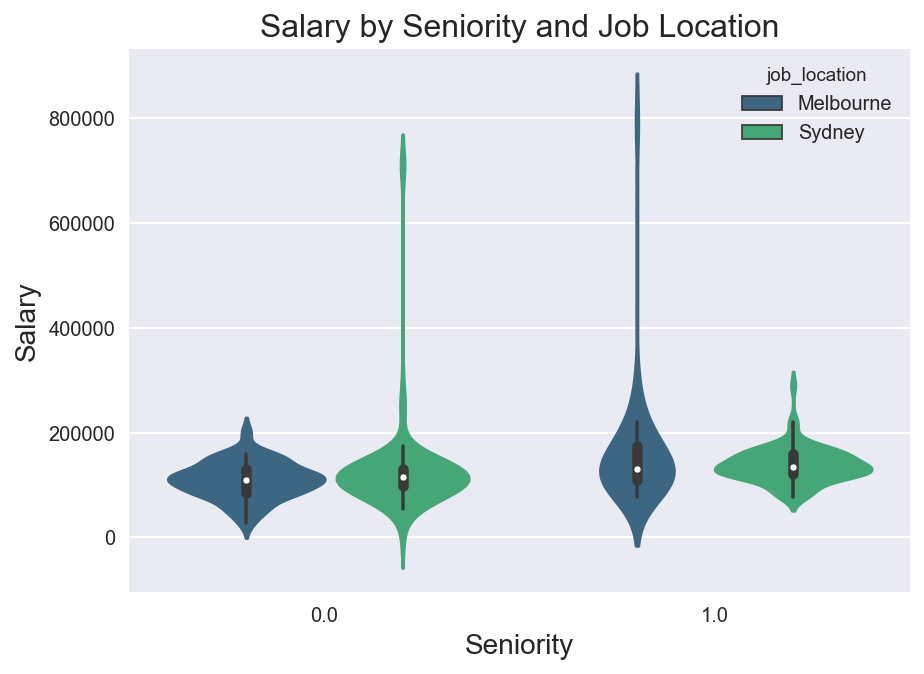

In [50]:
plt.figure(figsize = (7,5))
sns.violinplot(x = subset['senior'], y = subset['salary'], hue = subset['job_location'], palette='viridis')
plt.title('Salary by Seniority and Job Location', fontsize = 16)
plt.xlabel('Seniority', fontsize = 14)
plt.ylabel('Salary', fontsize = 14);

plt.savefig('violinplot.png', bbox_inches='tight', dpi=150)

In [51]:
def convert_camelcase(name):
    '''Convert CamelCase to camel case'''
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1 \2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1 \2', s1).lower()

exclude = set(string.punctuation)

for col in ['job_title', 'job_description', 'job_text', 'job_industry', 'job_sub_industry']:
    for idx, row in df.iterrows():
        s = row[col]
        s = ''.join(ch for ch in s if ch not in exclude)
        s = convert_camelcase(s)
        df.loc[idx, col] = s.replace('  ',' ')
    df[col] = df[col].str.replace('  ', ' ')

In [52]:
# creating encoding the industry fields as dummy variables 
dummies = pd.get_dummies(df[['job_industry', 'job_employment_type', 'job_location']], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
df.drop(['job_industry', 'job_employment_type', 'job_location'], axis = 1, inplace = True)

In [53]:
# job_location
# df.columns

In [54]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor

In [55]:
# 'job_industry_advertising arts media',
#         'job_industry_banking financial services', 'job_industry_consulting strategy', 
#         'job_industry_education training', 'job_industry_engineering', 
#         'job_industry_government defence', 'job_industry_healthcare medical',
#         'job_industry_human resources recruitment', 'job_industry_information communication technology',
#         'job_industry_insurance superannuation', 'job_industry_manufacturing transport logistics',
#         'job_industry_marketing communications','job_industry_mining resources energy', 'job_industry_sales',
#         'job_industry_science technology', 'job_industry_trades services',
#         'job_employment_type_Full Time', 'job_employment_type_Part Time',

X = df[['senior', 'description_len', 'job_text', 'job_location_Sydney', 'job_location_Melbourne']].copy()

y = df['salary'].values

In [56]:
#             'rdg': RidgeCV(),
#             'las': LassoCV(),
#             'rdg_bag': BaggingRegressor(RidgeCV(), random_state=42),
#             'las_bag': BaggingRegressor(LassoCV(), random_state=42),

regressors={'gbr': GradientBoostingRegressor(random_state=42),
            'gbr_bag': BaggingRegressor(GradientBoostingRegressor(random_state=42), random_state=42),
            'abr': AdaBoostRegressor(random_state=42),
            'abr_bag': BaggingRegressor(AdaBoostRegressor(), random_state=42),
            'rfr': RandomForestRegressor(n_estimators=200, random_state=42)}

In [57]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [58]:
results = {}
for i in range(100, 500, 25):
    temp_results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # reinstantiatng the tf idf vectorizer object
    tf = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english', max_features=i)
    
    X_train_text = pd.DataFrame(data = tf.fit_transform(X_train['job_text']).todense(),
                                columns = tf.get_feature_names())
    X_test_text = pd.DataFrame(data = tf.transform(X_test['job_text']).todense(),
                               columns = tf.get_feature_names())

    X_train = pd.concat([X_train.reset_index(), X_train_text], axis = 1)
    X_test = pd.concat([X_test.reset_index(), X_test_text], axis = 1)

    X_train.drop('job_text', axis = 1, inplace = True)
    X_test.drop('job_text', axis = 1, inplace = True)
    
    X_train.iloc[:, :20] = ss.fit_transform(X_train.iloc[:,:20])
    X_test.iloc[:, :20] = ss.transform(X_test.iloc[:,:20])
    
    for reg in regressors.items():
        reg[1].fit(X_train, y_train)
        temp_results.append([reg[0], reg[1].score(X_test, y_test)])
    results.update({i: temp_results})

In [59]:
best_score = ['reg', 'max_features', 0]
for i, clf in enumerate(regressors):
    for k in results.keys():
        if results[k][i][1] > best_score[2]:
            best_score = [results[k][i][0], k, results[k][i][1]]

In [60]:
best_score

['gbr', 400, 0.71691467520703578]

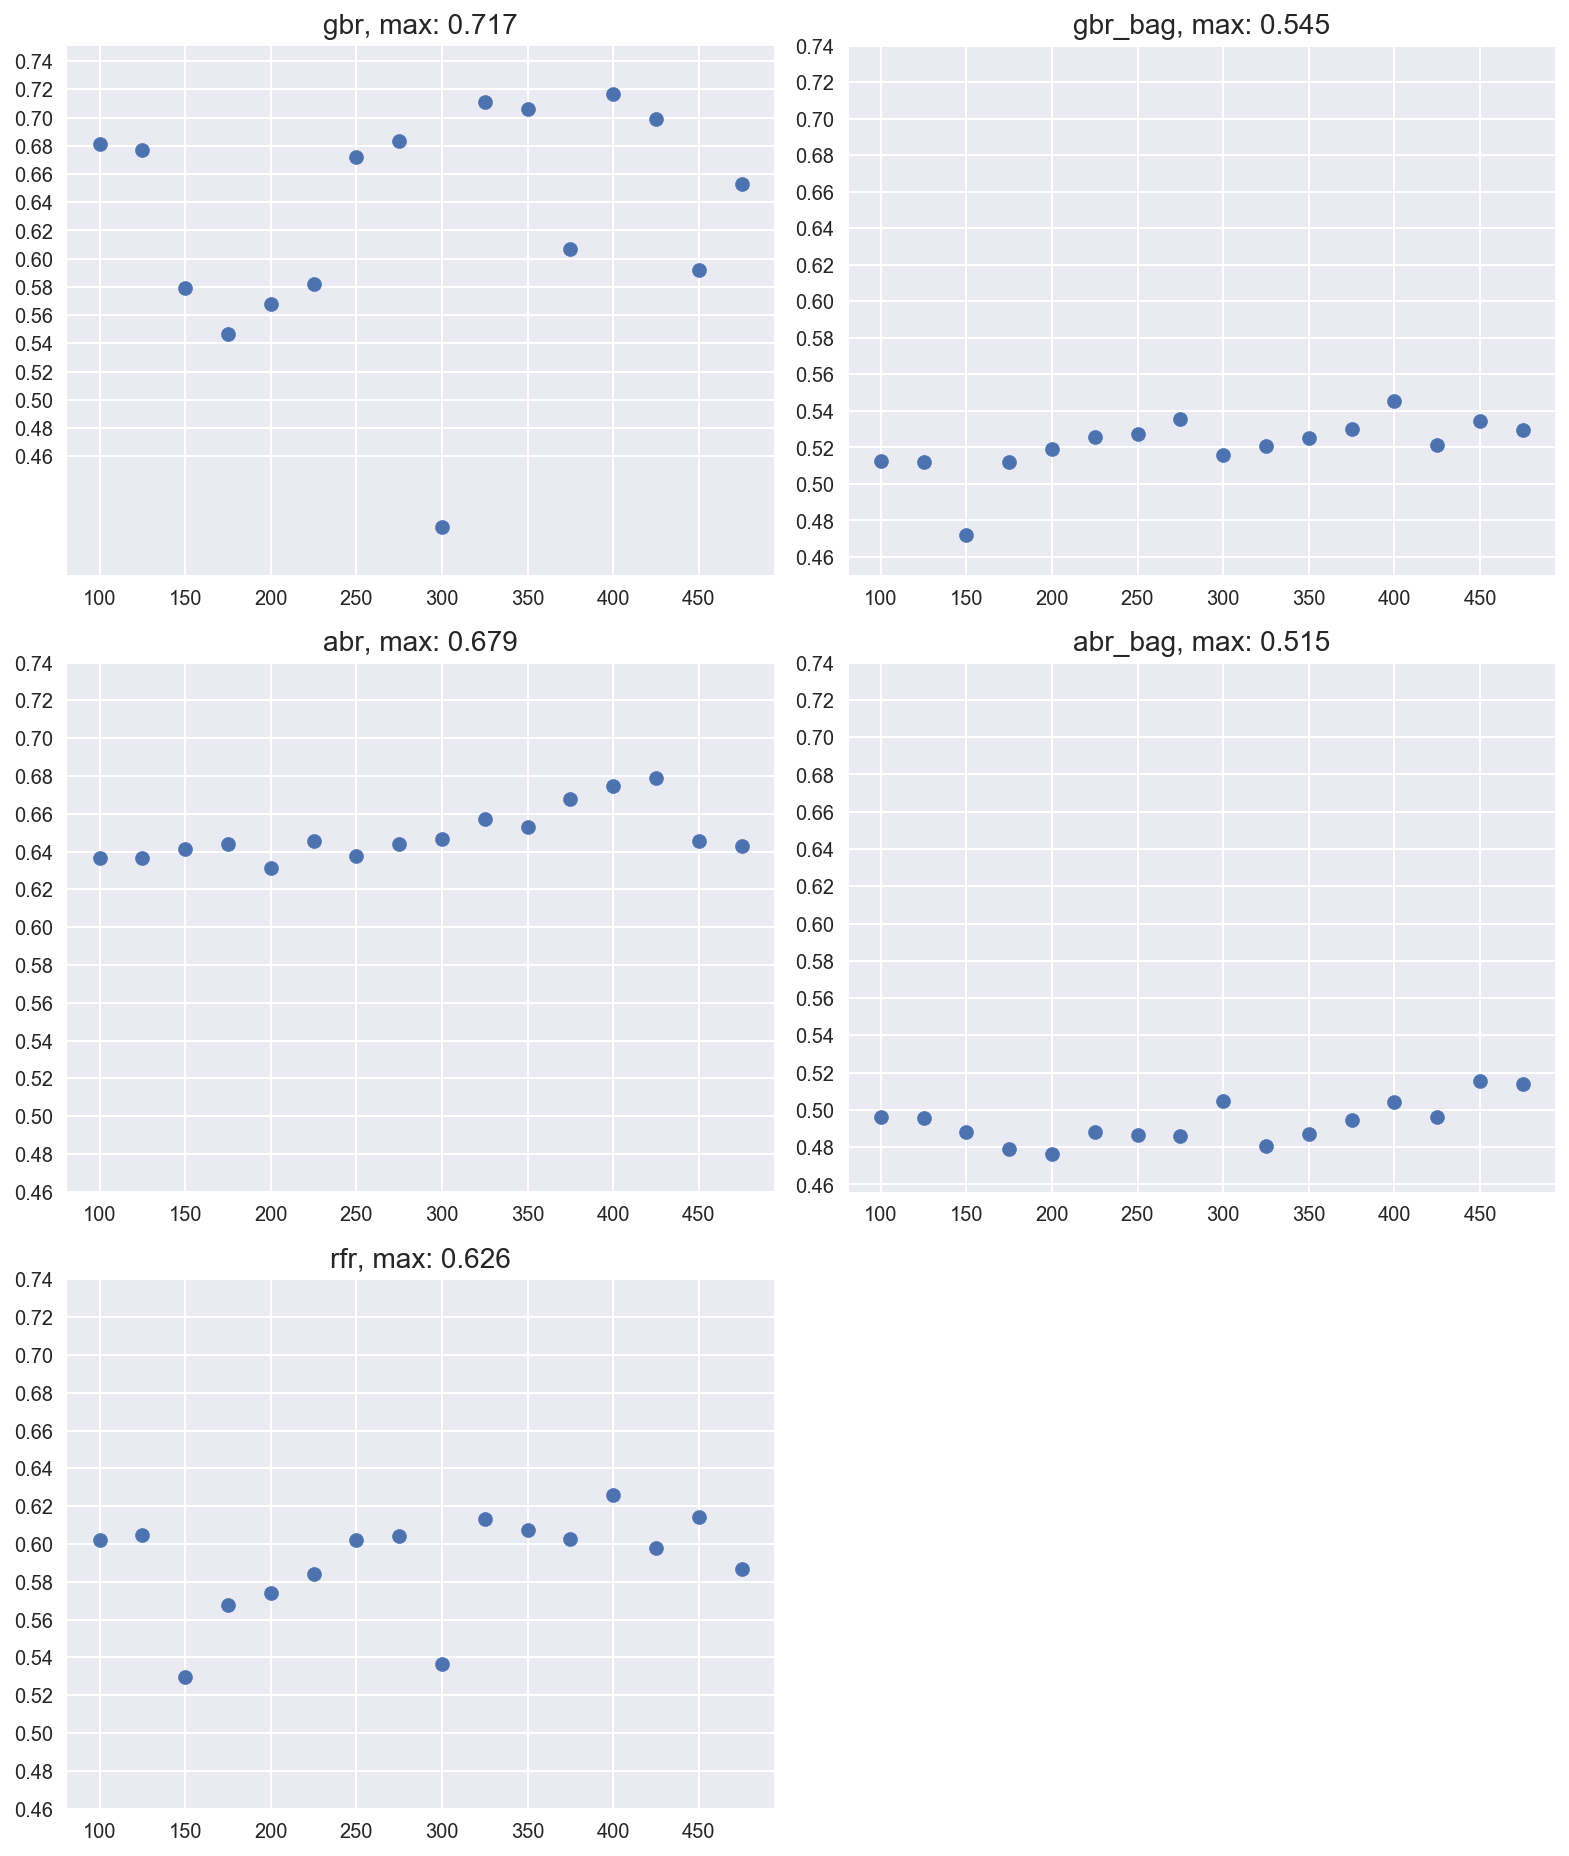

In [61]:
plt.figure(figsize = (11,13))
for i, reg in enumerate(regressors):
    y_coords = []
    for k in results.keys():
        y_coords.append(results[k][i][1])
    plt.subplot(3,2,i+1), plt.scatter(x = list(range(100, 500, 25)), y = y_coords)
    plt.title(str(reg) + ', max: {}'.format(round(max(y_coords),3)), fontsize = 14)
    plt.yticks(np.arange(0.46, 0.76, 0.02))
plt.tight_layout()

In [62]:
from sklearn.decomposition import PCA, TruncatedSVD

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# reinstantiatng the tf idf vectorizer object
tf = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english', max_features=450)

X_train_text = pd.DataFrame(data = tf.fit_transform(X_train['job_text']).todense(),
                            columns = tf.get_feature_names())
X_test_text = pd.DataFrame(data = tf.transform(X_test['job_text']).todense(),
                           columns = tf.get_feature_names())

X_train = pd.concat([X_train.reset_index(), X_train_text], axis = 1)
X_test = pd.concat([X_test.reset_index(), X_test_text], axis = 1)

X_train.drop('job_text', axis = 1, inplace = True)
X_test.drop('job_text', axis = 1, inplace = True)

In [64]:
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

pca = PCA()
pca.fit(X_train_s)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [65]:
components_train = pca.transform(X_train_s)
components_test = pca.transform(X_test_s)

In [66]:
components_train.shape

(397, 397)

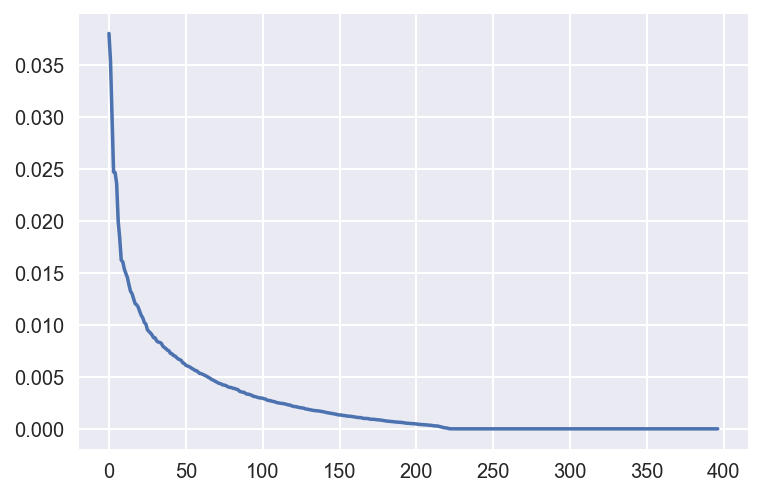

In [67]:
plt.plot(pca.explained_variance_ratio_);

In [68]:
X_pca_train = components_train.T[:35]
X_pca_test = components_test.T[:35]

In [69]:
# PCA did not really help
gbr = GradientBoostingRegressor()
gbr.fit(X_pca_train.T, y_train)
gbr.score(X_pca_test.T, y_test)

0.54407150429369966

### Executive Summary

Web scraping job adverts from websites such as seek.com or indeed.com can allow insights into how features such as pay, location, and share of overall employment are distributed across the various sectors. 

Web scraping primarily involves researching the layout of webpages of interest in order to identify commonalities. This step is crucial because any web scraping code needs to be scaled such that the code will provide the desired results across thousands of web pages. Once code is written, it needs to be tested on multiple web pages in order to ensure that the layout remained consistent.

However, despite thorough research and testing, there will always be variability in the layout of job posting web pages because the job poster actually creates the job advert. This can lead to discrepancy, or holes in the data, which may indicate that the feature is useless. More dangerously, this can alternatively lead to features getting mixed up when web scraped. This will muddle features, and can easily pass unnoticed.

Job postings  relating to Data Science were scraped by passing the url corresponding to a search for a position or software used within the whole of Australia. Additionally, another search for Business Analyst was passed.

Once the jobs were scraped, the data needed to be cleaned. Jobs were removed if they didn’t have an associated salary, or if the salary provided corresponded to daily or hourly rates.

In order to classify jobs, the data was divided into jobs that came from the Business Analyst search, and jobs that didn’t (Data Science). From there, a model was trained using the count of words in the short description, in addition to the actual job text of the job listing. The job text was used by counting the occurrences of each word in each listing (of which there were ~2,000 on average), and scaling significance of each word by its prevalence against all of the other words from all of the other jobs.

Assuming perfect data (e.g. all jobs were labeled correctly and additionally consisted of work that would be characteristic of a Data Scientist or Business Analyst), the model was very effective, classifying roles correctly 80% of the time.

Predicting job salary proved to be more difficult. The predictive models’ features included the count of words in the description, the industry fields, and the text of the job title instead of the actual job text. The model performed better when only run on jobs labeled as Data Science, predicting the salary with differences of ~30% from the true salary. That said, the prediction algorithm was not consistent, and is therefore not very reliable. 
When applied to the entirety of the data, the model performed much worse, predicting with differences of ~70-75% from the true salary.

### Combining Webscrape Results into DataFrame

This is initially how I processed the files from the other workbook. I saved the resulting output to a csv file, making these cells obsolete

In [70]:
# paths = './Data/*.csv'

# # load all csv files of scraped jobs into one dataframe
# for i, fpath in enumerate(glob.glob(paths)):
#     if i == 0:
#         df = pd.read_csv(fpath, index_col=0)
#         df['file'] = fpath.split('/')[-1].split('.')[0]
#     else:
#         temp_df = pd.read_csv(fpath, index_col=0)
#         temp_df['file'] = fpath.split('/')[-1].split('.')[0]
#         df = pd.concat([df, temp_df])

# df.reset_index(inplace = True, drop = True)

# # job salary was always in a list one element long. iterate through salaries, and save 
# # a cleaned version of the text to the dataframe
# d = {}

# for idx, row in df.iterrows():
#     try:
#         row['job_salary'][0]
#         job_salary = row['job_salary'].split('[\'')[1].split('\']')[0].split(': ')[1]
#         d.update({idx : job_salary})
#     except: 
#         IndexError
#         d.update({idx : np.NaN})
        
# df['job_salary'] = d.values()

# # drop all lines that don't have a salary
# df = df[df['job_salary'].isnull() == False]

# # map 'Unknown' to job_sub_locations that were zero
# df.loc[(df['job_sub_location'] == '0'), 'job_sub_location'] = 'Unknown'

# df.drop_duplicates(inplace = True)

# df.reset_index(inplace = True, drop = True)

In [71]:
# # drop salaries that don't contain any numerics
# text_only = []
# for i, item in enumerate(df['job_salary']):
#     for num in range(10):
#         if str(num) in item:
#             break
#         elif num == 9:
#             text_only.append(i)

In [72]:
# # removing salaries without values
# df.drop(text_only, axis = 0, inplace = True)
# df.reset_index(inplace = True, drop = True)

In [73]:
# # creating column to flag salary rows which have k instead of ',000'
# k_d = {}
# # grab any amount of numerics that are followed by 'k' or 'K'
# regex_str = r'\d+k|\d+K'

# regex = re.compile(regex_str)
# for i, val in enumerate(df['job_salary']):
      # # skip rows that don't match the regex pattern
#     if regex.findall(val) != []:
          # # place instances with multiple values in one string
#         if len(regex.findall(val)) > 1:   
#             k_d.update({i: (', ').join(regex.findall(val))})
          # # otherwise, just place the one value
#         else:
#             k_d.update({i : regex.findall(val)[0]})

# len(k_d)

In [74]:
# # iterate through the values the regex selected, 
# # give a once over to make sure nothing is out of place
# for k in k_d.keys():
#     print(k)
#     print(k_d[k])
#     print(df.loc[k,'job_salary'])
#     print()

In [75]:
# # creating column to flag salary rows which have commas
# comma_d = {}
# # grab any salaries with numerics separated by a comma
# regex_str = r'\d+,\d+'

# regex = re.compile(regex_str)
# for i, val in enumerate(df['job_salary']):
#     if regex.findall(val) != []:
#         if len(regex.findall(val)) > 1:   
#             comma_d.update({i: (', ').join(regex.findall(val))})
#         else:
#             comma_d.update({i : regex.findall(val)[0]})
            
# len(comma_d)

In [76]:
# # print the values of overlap between keys
# # remove duplicated key from k_d or comma_d depending on the value
# for k in comma_d.keys():
#     if k in k_d.keys():
#         print(k)

In [77]:
# # give comma_d a once over
# for k in comma_d.keys():
#     print(k)
#     print(comma_d[k])
#     print(df.loc[k,'job_salary'])
#     print()

In [78]:
# # creating column to flag salary rows which are just numbers
# num_d = {}
# regex_str = r'\d+\d+\d+\d+\d+\d+'

# regex = re.compile(regex_str)
# for i, val in enumerate(df['job_salary']):
#     if regex.findall(val) != []:
#         if len(regex.findall(val)) > 1:   
#             num_d.update({i: (', ').join(regex.findall(val))})
#         else:
#             num_d.update({i : regex.findall(val)[0]})
            
# len(num_d)

In [79]:
# # overlap between keys
# for k in num_d.keys():
#     if k in k_d.keys():
#         print(k)

In [80]:
# # what the overlapping keys between num_d and k_d look like
# df.loc[[504, 1047, 1219, 1367], 'job_salary']

In [81]:
# # overlap between keys
# for k in num_d.keys():
#     if k in comma_d.keys():
#         print(k)

In [82]:
# # remove overlapping keys from num_d because they are better suited to k_d
# del num_d[504], num_d[1047], num_d[1219], num_d[1367]

In [83]:
# # once over
# for k in num_d.keys():
#     print(k)
#     print(num_d[k])
#     print(df.loc[k,'job_salary'])
#     print()

Create columns for the dictionaries so that the dataframe can easily be filtered by salaries. For example, filtering df['salary_k'].isnull() == False will only rows for which the regex used to create k_d picked up values

In [84]:
# df['salary_k'] = np.nan
# for k in k_d.keys():
#     df.loc[k, 'salary_k'] = k_d[k]
    
# df['salary_comma'] = np.nan
# for k in comma_d.keys():
#     df.loc[k, 'salary_comma'] = comma_d[k]
    
# df['salary_num'] = np.nan
# for k in num_d.keys():
#     df.loc[k, 'salary_num'] = num_d[k]

Create columns to hold extracted salaries from flagged columns. The lower and upper columns will hold the first and second (if applicable) values in the raw salary column, once extracted by the corresponding dictionary (k_d, comma_d, num_d)

Said another way, every row will have a lower value, only rows with multiple values extracted by regex will have an upper value, which are to be filled by the second value

The lower and upper columns will be processed, and the resulting output will be placed in the salary column

In [85]:
# df['salary_lower'] = np.nan
# df['salary_upper'] = np.nan
# df['salary'] = np.nan

The lower, upper and salary columns are populated below. Recall that the dictionaries are indexed by row indices in the dataframe. The values are cleaned, masked to in the lower and/or upper columns using the dataframe indices, which are then masked to the salary column

In [86]:
# for idx, _ in df[df['salary_k'].isnull() == False].iterrows():
      # # determine if there are one or two values for a row index
#     if ',' in k_d[idx]:
          # # replacing the k with 000 to turn 100k into 100000
#         df.loc[idx, 'salary_lower'] = int(k_d[idx].split(', ')[0].lower().replace('k','000'))
#         df.loc[idx, 'salary_upper'] = int(k_d[idx].split(', ')[1].lower().replace('k','000'))
#         df.loc[idx, 'salary'] = np.mean([df.loc[idx, 'salary_lower'], 
#                                          df.loc[idx, 'salary_upper']])
#     else:
#         df.loc[idx, 'salary_lower'] = int(k_d[idx].lower().replace('k','000'))
#         df.loc[idx, 'salary'] = df.loc[idx, 'salary_lower']

In [87]:
# for idx, row in df[df['salary_comma'].isnull() == False].iterrows():
#     if len(comma_d[idx].split(', ')) > 1:
          # # these values have the proper number of zeros, but the commas force pandas to interpret the columns as objects
#         df.loc[idx, 'salary_lower'] = int(comma_d[idx].split(', ')[0].replace(',', ''))
#         df.loc[idx, 'salary_upper'] = int(comma_d[idx].split(', ')[1].replace(',', ''))
#         df.loc[idx, 'salary'] = np.mean([df.loc[idx, 'salary_lower'], 
#                                          df.loc[idx, 'salary_upper']])
        
#     else:
#         df.loc[idx, 'salary_lower'] = int(comma_d[idx].replace(',', ''))
#         df.loc[idx, 'salary'] = df.loc[idx, 'salary_lower']

In [88]:
# for idx, _ in df[df['salary_num'].isnull() == False].iterrows():
#     if ',' in num_d[idx]:
          # # these values are nearly set, they just need to be masked
#         df.loc[idx, 'salary_lower'] = int(num_d[idx].split(', ')[0])
#         df.loc[idx, 'salary_upper'] = int(num_d[idx].split(', ')[1])
#         df.loc[idx, 'salary'] = np.mean([df.loc[idx, 'salary_lower'], 
#                                          df.loc[idx, 'salary_upper']])
#     else:
#         df.loc[idx, 'salary_lower'] = int(num_d[idx])
#         df.loc[idx, 'salary'] = df.loc[idx, 'salary_lower']

In [89]:
# # adding a length of description to each row
# for idx, row in df.iterrows():
#     length = 0
#     length = len(row['job_description'].split(' '))
#     df.loc[idx, 'description_len'] = length